# 2023 인공지능연구회 강습회 실습
# (강사: 숙명여자대학교 심주용 - 2023.08.16)
# Lab3: FCN, Object Detection, RNN


# 1.Fully Convolutional Networks (FCN)

- FCN is built only from locally connected layers, such as convolution, pooling and upsampling.
- Note that no dense layer is used in this kind of architecture.
- Network can work regardless of the original image size, without requiring any fixed number of units at any stage.
- To obtain a segmentation map (output), segmentation networks usually have 2 parts

    1. Downsampling path: capture semantic/contextual information
    2. Upsampling path: recover spatial information

- The downsampling path is used to extract and interpret the context (what), while the upsampling path is used to enable precise localization (where).
- Furthermore, to fully recover the fine-grained spatial information lost in the pooling or downsampling layers, we often use skip connections.
- Given a position on the spatial dimension, the output of the channel dimension will be a category prediction of the pixel corresponding to the location.

https://i-systems.github.io/teaching/DL/iNotes_tf2/12_FCN_tf2.html


## 1.1 Dataset for Segmentation

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

- Segmentation task is different from classification task because it requires predicting a class for each pixel of the input image, instead of only 1 class for the whole input.
- Classification needs to understand what is in the input (namely, the context).
- However, in order to predict what is in the input for each pixel, segmentation needs to recover not only what is in the input, but also where.
- Segment images into regions with different semantic categories. These semantic regions label and predict objects at the pixel level


https://www.tensorflow.org/tutorials/images/segmentation

 ![GT](https://www.tensorflow.org/static/tutorials/images/segmentation_files/output_a6u_Rblkteqb_1.png)

In [ ]:
!wget https://www.dropbox.com/s/8eauz8nnill1n8c/images_training.npy
!wget https://www.dropbox.com/s/563go90a7qkioc7/images_testing.npy
!wget https://www.dropbox.com/s/cydl62wezz5ie7a/seg_training.npy

The number of training images : 180, shape : (180, 224, 224, 3)
The number of segmented images : 180, shape : (180, 224, 224, 2)
The number of testing images : 27, shape : (27, 224, 224, 3)


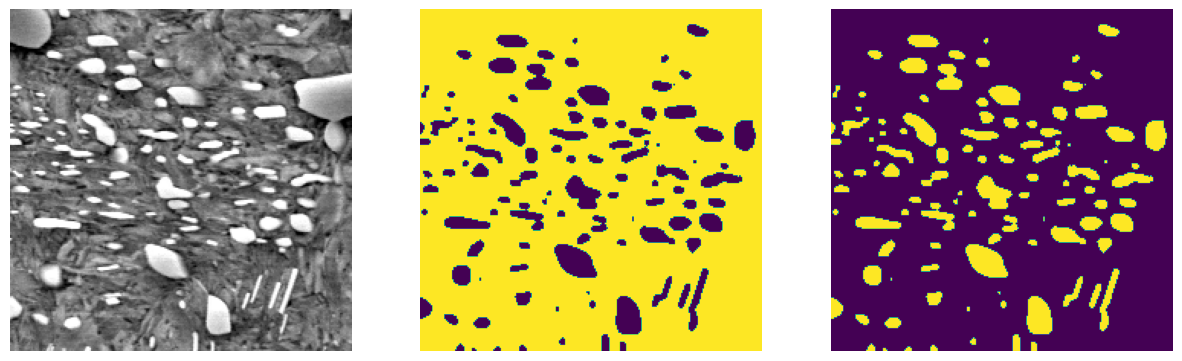

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
train_imgs = np.load('images_training.npy')
train_seg = np.load('seg_training.npy')
test_imgs = np.load('images_testing.npy')

n_train = train_imgs.shape[0]
n_test = test_imgs.shape[0]

print ("The number of training images : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of segmented images : {}, shape : {}".format(n_train, train_seg.shape))
print ("The number of testing images : {}, shape : {}".format(n_test, test_imgs.shape))

idx = np.random.randint(n_train)

plt.figure(figsize = (15,10))
plt.subplot(1,3,1)
plt.imshow(train_imgs[idx])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train_seg[idx][:,:,0])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train_seg[idx][:,:,1])
plt.axis('off')
plt.show()

## 1.2. Utilize VGG16 Model for Encoder

![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/seg_model.png)

In [3]:
model_type = tf.keras.applications.vgg16
base_model = model_type.VGG16()
base_model.trainable = False
base_model.summary()

553467096/553467096 [==============================] - 14s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

## 1.3 Build a FCN Model
- tf.layers are used to define upsampling parts
![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/seg_model.png)

In [4]:
map5 = base_model.layers[-5].output

# sixth convolution layer
conv6 = tf.keras.layers.Conv2D(filters = 4096,
                               kernel_size = (7,7),
                               padding = 'SAME',
                               activation = 'relu')(map5)

# 1x1 convolution layers
fcn4 = tf.keras.layers.Conv2D(filters = 4096,
                              kernel_size = (1,1),
                              padding = 'SAME',
                              activation = 'relu')(conv6)

fcn3 = tf.keras.layers.Conv2D(filters = 2,
                              kernel_size = (1,1),
                              padding = 'SAME',
                              activation = 'relu')(fcn4)

# Upsampling layers
fcn2 =  tf.keras.layers.Conv2DTranspose(filters = 512,
                                        kernel_size = (4,4),
                                        strides = (2,2),
                                        padding = 'SAME')(fcn3)

fcn1 =  tf.keras.layers.Conv2DTranspose(filters = 256,
                                        kernel_size = (4,4),
                                        strides = (2,2),
                                        padding = 'SAME')(fcn2 + base_model.layers[14].output)

output =  tf.keras.layers.Conv2DTranspose(filters = 2,
                                          kernel_size = (16,16),
                                          strides = (8,8),
                                          padding = 'SAME',
                                          activation = 'softmax')(fcn1 + base_model.layers[10].output)

model = tf.keras.Model(inputs = base_model.inputs, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

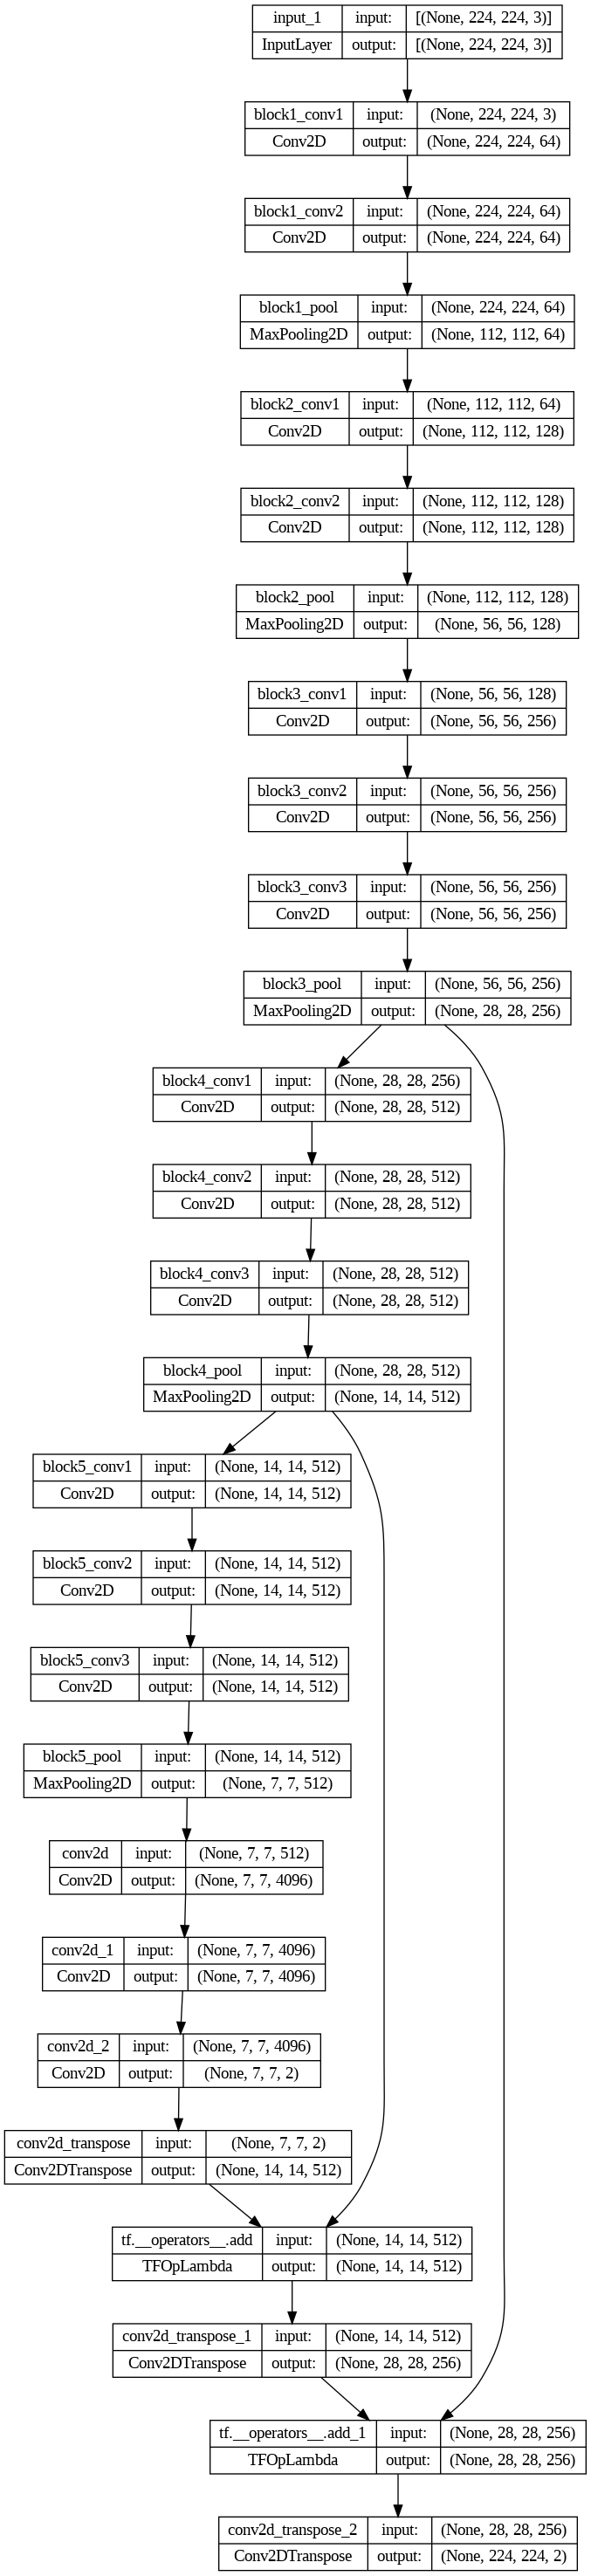

In [5]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 1.4. Training

In [6]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = 'accuracy')
model.fit(train_imgs, train_seg, batch_size = 5, epochs = 5)

Epoch 1/5
36/36 [==============================] - 16s 70ms/step - loss: 0.5494 - accuracy: 0.8600
Epoch 2/5
36/36 [==============================] - 3s 70ms/step - loss: 0.2442 - accuracy: 0.9095
Epoch 3/5
36/36 [==============================] - 3s 70ms/step - loss: 0.2096 - accuracy: 0.9193
Epoch 4/5
36/36 [==============================] - 3s 71ms/step - loss: 0.2024 - accuracy: 0.9216
Epoch 5/5
36/36 [==============================] - 3s 70ms/step - loss: 0.1951 - accuracy: 0.9244


## 1.5. Testing

1/1 [==============================] - 1s 644ms/step


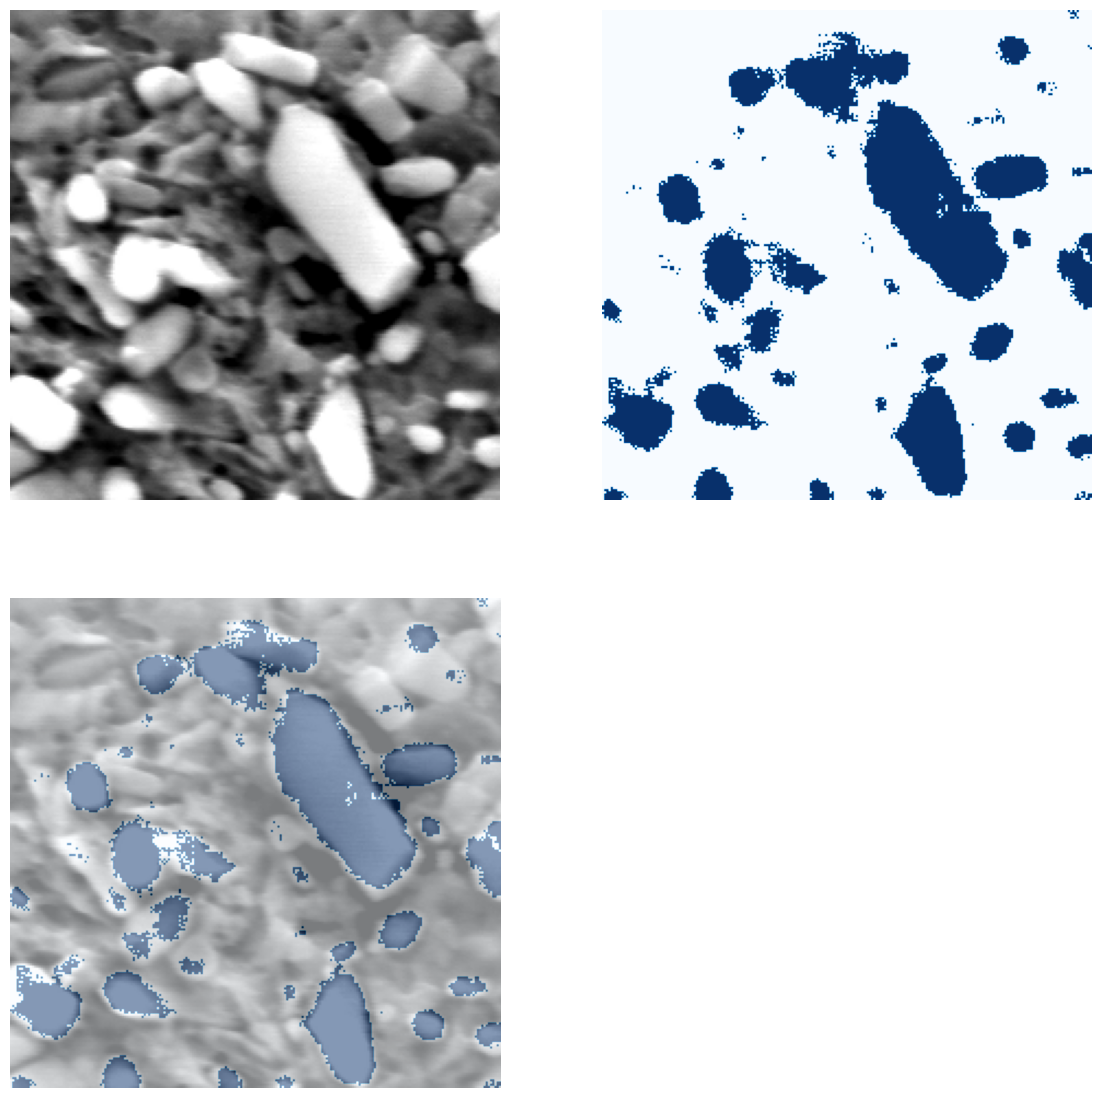

In [7]:
test_x = test_imgs[[1]]
test_seg = model.predict(test_x)

seg_mask = (test_seg[:,:,:,1] > 0.5).reshape(224, 224, 1).astype(float)

plt.figure(figsize = (14,14))
plt.subplot(2,2,1)
plt.imshow(test_x[0])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(seg_mask, cmap = 'Blues')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(test_x[0])
plt.imshow(seg_mask, cmap = 'Blues', alpha = 0.5)
plt.axis('off')
plt.show()

# 2.Object Detection
![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/od_model.png)

## 2.1 Load Machinery Parts Dataset
- 2-D convolution layers extract features from the input image.
- Extracted features are utilized for object bounding box detection and object classification
- Both classifier and bounding box regressor share the same features acuired from the 2-D convolution layers

https://i-systems.github.io/teaching/DL/iNotes_tf2/15_Object_Detection_tf2.html

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [9]:
!wget https://www.dropbox.com/s/q018u8xjpgw1o08/object_detction_trn_data.npy
!wget https://www.dropbox.com/s/n2tbpv711noece1/object_detction_trn_label.npy
!wget https://www.dropbox.com/s/sup33lt7hmpml49/object_detction_eval_data.npy
!wget https://www.dropbox.com/s/2xi5naxkyw8a4cz/object_detction_eval_label.npy

--2023-08-15 17:44:30--  https://www.dropbox.com/s/q018u8xjpgw1o08/object_detction_trn_data.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/q018u8xjpgw1o08/object_detction_trn_data.npy [following]
--2023-08-15 17:44:30--  https://www.dropbox.com/s/raw/q018u8xjpgw1o08/object_detction_trn_data.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc3030b996c6d3aa48b8bba92fa.dl.dropboxusercontent.com/cd/0/inline/CB3LvrRu95ueEQ39NSiZRPS14SaLUHJZXyAz2rBA0MQLSHRLodnZ_zouDy4QD4SYFpaBBU4so7CuQMo92fIirM0eF63e-cW9inFR83ggbfenjq9gzPzZFKwW8-ZizDwIho5MFovup2rqoHeBXi1OHU6N/file# [following]
--2023-08-15 17:44:31--  https://ucc3030b996c6d3aa48b8bba92fa.dl.dropboxusercontent.com/cd/0/inline/CB3LvrRu95ueEQ39NSiZRPS14SaLUHJZXyAz2rBA0MQLSHRLodn

In [10]:
train_imgs = np.load('object_detction_trn_data.npy')
train_labels = np.load('object_detction_trn_label.npy')

test_imgs = np.load('object_detction_eval_data.npy')
test_labels = np.load('object_detction_eval_label.npy')

# input image: 240 by 320
# output label: class, x, y, h, w

classes = ['Axis',
           'Bearing',
           'Bearing_Box',
           'Distance_Tube',
           'F20_20_B']

In [11]:
test_imgs.shape

(60, 240, 320, 3)

- Five classes images are availabe: Axis, bearing, bearing box, distance tube, beam

- 250 images are used for training (50 images per class)

- 50 images are avalialbe for evaluation (10 images per class)

- One object per image (240 by 320)

- Labeled with class and bounding box location(normalizsed): class,  x,y,h,w

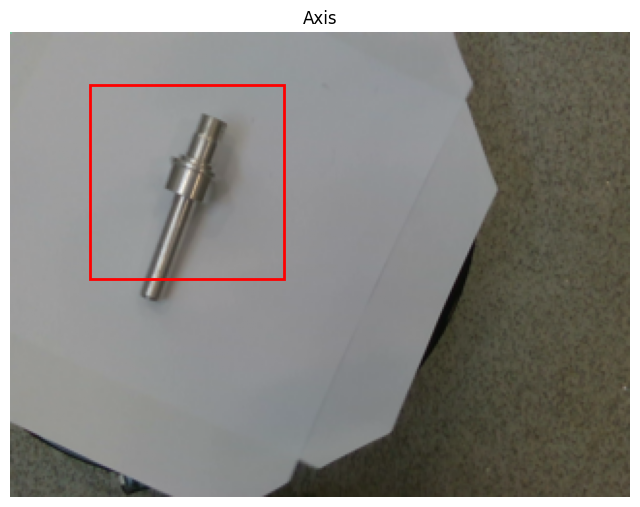

In [12]:
idx = 138

train_img = train_imgs[idx]
c, x, y, h, w = train_labels[idx]

# rescaling
x, w = x*320, w*320
y, h = y*240, h*240

rect = patches.Rectangle((x, y),
                         w,
                         h,
                         linewidth = 2,
                         edgecolor = 'r',
                         facecolor = 'none')

fig, ax = plt.subplots(figsize = (8,8))
plt.title(classes[int(c)])
plt.imshow(train_img)
ax.add_patch(rect)
plt.axis('off')
plt.show()

In [13]:
# rescaling output labels

train_labels = np.multiply(train_labels, [1, 320, 240, 320, 240])
test_labels = np.multiply(test_labels, [1, 320, 240, 320, 240])

## 2.2. Define and Build an Object Detection Model

![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/od_model.png)

In [14]:
feature_extractor = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = (3,3),
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (240, 320, 3)),

    tf.keras.layers.MaxPool2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'SAME'),

    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'SAME'),

    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'SAME'),

    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'SAME'),

    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'SAME'),

    tf.keras.layers.GlobalAveragePooling2D()
])

In [15]:
classifier = tf.keras.layers.Dense(256, activation = 'relu')(feature_extractor.output)
classifier = tf.keras.layers.Dense(256, activation = 'relu')(classifier)
classifier = tf.keras.layers.Dense(5, activation = 'softmax', name = 'cls')(classifier)
bb_regressor = tf.keras.layers.Dense(256, activation = 'relu')(feature_extractor.output)
bb_regressor = tf.keras.layers.Dense(256, activation = 'relu')(bb_regressor)
bb_regressor = tf.keras.layers.Dense(4, name = 'bbox')(bb_regressor)
object_detection = tf.keras.models.Model(inputs = feature_extractor.input,
                                         outputs = [classifier, bb_regressor])
object_detection.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_3_input (InputLayer)    [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 240, 320, 32  896         ['conv2d_3_input[0][0]']         
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 120, 160, 32  0           ['conv2d_3[0][0]']               
                                )                                                           

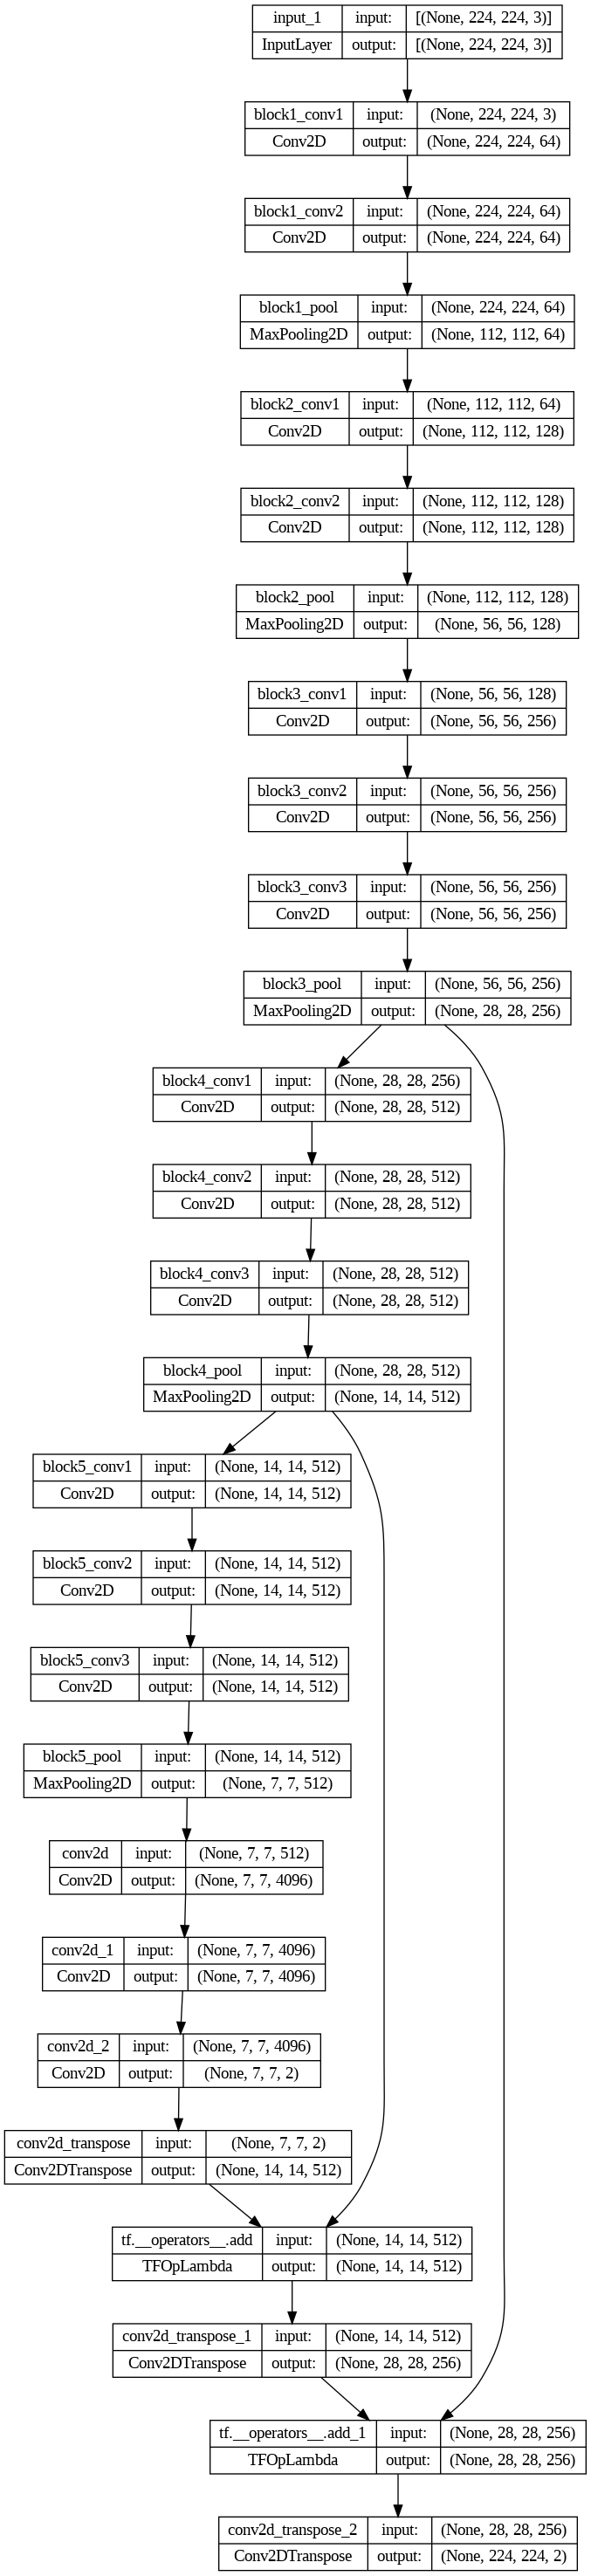

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)


## 2.3. Define Losses and Optimization Configuration


In [17]:
object_detection.compile(optimizer = 'adam',
                         loss = {'cls': 'sparse_categorical_crossentropy',
                                 'bbox': 'mse'},
                         loss_weights = {'cls': 1,
                                         'bbox': 1})
# divide labels to cls and bbox labels

train_cls = train_labels[:,:1]
train_bbox = train_labels[:,1:]

print(train_labels.shape)
print(train_cls.shape)
print(train_bbox.shape)

(240, 5)
(240, 1)
(240, 4)


In [24]:
object_detection.fit(x = train_imgs,
                     y = {'cls': train_cls, 'bbox': train_bbox},
                     epochs = 100)

Epoch 1/100
8/8 [==============================] - 0s 55ms/step - loss: 1507.9574 - cls_loss: 1.7103 - bbox_loss: 1506.2472
Epoch 2/100
8/8 [==============================] - 0s 53ms/step - loss: 1441.9354 - cls_loss: 1.6796 - bbox_loss: 1440.2557
Epoch 3/100
8/8 [==============================] - 1s 65ms/step - loss: 1409.3254 - cls_loss: 1.7229 - bbox_loss: 1407.6024
Epoch 4/100
8/8 [==============================] - 0s 51ms/step - loss: 1471.4353 - cls_loss: 1.7617 - bbox_loss: 1469.6737
Epoch 5/100
8/8 [==============================] - 1s 68ms/step - loss: 1411.7072 - cls_loss: 1.7174 - bbox_loss: 1409.9897
Epoch 6/100
8/8 [==============================] - 1s 66ms/step - loss: 1389.4806 - cls_loss: 1.7974 - bbox_loss: 1387.6833
Epoch 7/100
8/8 [==============================] - 1s 76ms/step - loss: 1435.1086 - cls_loss: 1.7008 - bbox_loss: 1433.4078
Epoch 8/100
8/8 [==============================] - 0s 62ms/step - loss: 1380.4716 - cls_loss: 1.7364 - bbox_loss: 1378.7351
Epoch 9/

## 2.4. Check Training Results


1/1 [==============================] - 0s 21ms/step
Bearing
Bearing


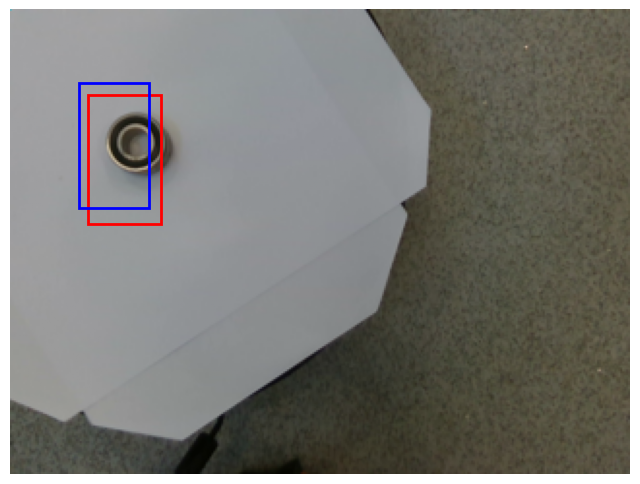

In [25]:
idx = 110

# true label
c_label, x_label, y_label, h_label, w_label = train_labels[idx]

rect_label = patches.Rectangle((x_label, y_label),
                               w_label,
                               h_label,
                               linewidth = 2,
                               edgecolor = 'r',
                               facecolor = 'none')

# predict
c_pred, bbox = object_detection.predict(train_imgs[[idx]])

x, y, h, w = bbox[0]
rect = patches.Rectangle((x, y),
                         w,
                         h,
                         linewidth = 2,
                         edgecolor = 'b',
                         facecolor = 'none')
print(classes[int(c_label)])
print(classes[np.argmax(c_pred)])

fig, ax = plt.subplots(figsize = (8,8))
plt.imshow(train_imgs[idx])
ax.add_patch(rect_label)
ax.add_patch(rect)
plt.axis('off')
plt.show()

## 2.5. Check Evaluation Results


1/1 [==============================] - 0s 21ms/step
Distance_Tube
Distance_Tube


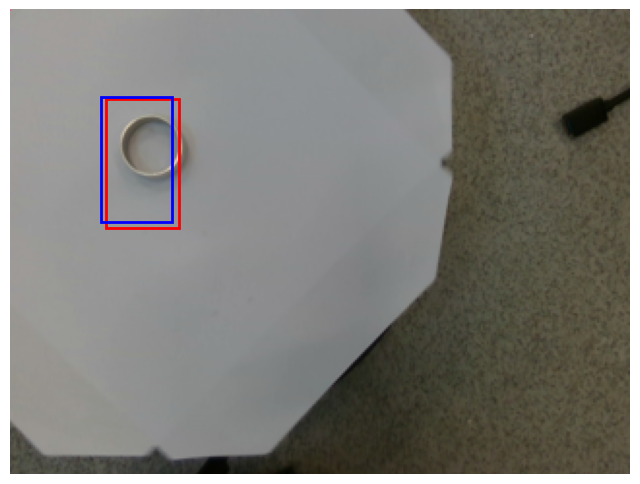

In [26]:
idx = 50

# true label
c_label, x_label, y_label, h_label, w_label = test_labels[idx]

rect_label = patches.Rectangle((x_label, y_label),
                               w_label,
                               h_label,
                               linewidth = 2,
                               edgecolor = 'r',
                               facecolor = 'none')

# predict
c_pred, bbox = object_detection.predict(test_imgs[[idx]])

x, y, h, w = bbox[0]
rect = patches.Rectangle((x, y),
                         w,
                         h,
                         linewidth = 2,
                         edgecolor = 'b',
                         facecolor = 'none')
print(classes[int(c_label)])
print(classes[np.argmax(c_pred)])


fig, ax = plt.subplots(figsize = (8,8))
plt.imshow(test_imgs[idx])
ax.add_patch(rect_label)
ax.add_patch(rect)
plt.axis('off')
plt.show()

# 3.Recurrent Neural Network (RNN)


## 3.1 LSTM with TensorFlow

 An example for predicting a next piece of an image Regression problem Again, MNIST dataset Time series data and RNN

https://i-systems.github.io/teaching/DL/iNotes_tf2/17_RNN_tf2.html

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from six.moves import cPickle

### Load rotation machinery data

In [ ]:
!wget https://www.dropbox.com/s/42dic65cf17o0eu/rnn_time_signal.pkl

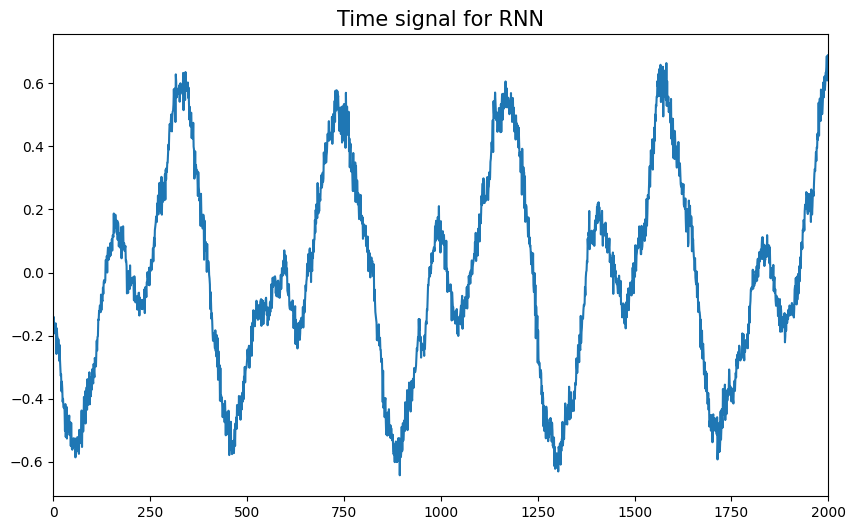

In [27]:
data =  cPickle.load(open('rnn_time_signal.pkl', 'rb'))

plt.figure(figsize = (10,6))
plt.title('Time signal for RNN', fontsize=15)
plt.plot(data[0:2000])
plt.xlim(0,2000)
plt.show()

## 3.2. LSTM Model Training

![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/rnn.png)

In [28]:

n_step = 25
n_input = 100

# LSTM shape
n_lstm1 = 100
n_lstm2 = 100

# fully connected
n_hidden = 100
n_output = 100
lstm_network = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (n_step, n_input)),
    tf.keras.layers.LSTM(n_lstm1, return_sequences = True),
    tf.keras.layers.LSTM(n_lstm2),
    tf.keras.layers.Dense(n_hidden),
    tf.keras.layers.Dense(n_output),
])

lstm_network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 100)           80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
Total params: 181,000
Trainable params: 181,000
Non-trainable params: 0
_________________________________________________________________


In [29]:
lstm_network.compile(optimizer = 'adam',
                     loss = 'mean_squared_error',
                     metrics = ['mse'])
def dataset(data, n_samples, n_step = n_step, dim_input = n_input, dim_output = n_output, stride = 5):

    train_x_list = []
    train_y_list = []
    for i in range(n_samples):
        train_x = data[i*stride:i*stride + n_step*dim_input]
        train_x = train_x.reshape(n_step, dim_input)
        train_x_list.append(train_x)

        train_y = data[i*stride + n_step*dim_input:i*stride + n_step*dim_input + dim_output]
        train_y_list.append(train_y)

    train_data = np.array(train_x_list)
    train_label = np.array(train_y_list)

    test_data = data[10000:10000 + n_step*dim_input]
    test_data = test_data.reshape(1, n_step, dim_input)

    return train_data, train_label, test_data
train_data, train_label, test_data = dataset(data, 5000)
lstm_network.fit(train_data, train_label, epochs = 3)

Epoch 1/3
157/157 [==============================] - 7s 9ms/step - loss: 0.0327 - mse: 0.0327
Epoch 2/3
157/157 [==============================] - 1s 9ms/step - loss: 0.0076 - mse: 0.0076
Epoch 3/3
157/157 [==============================] - 3s 20ms/step - loss: 0.0055 - mse: 0.0055


## 3.3. Testing or Evaluating
- Predict future time signal

1/1 [==============================] - 1s 645ms/step


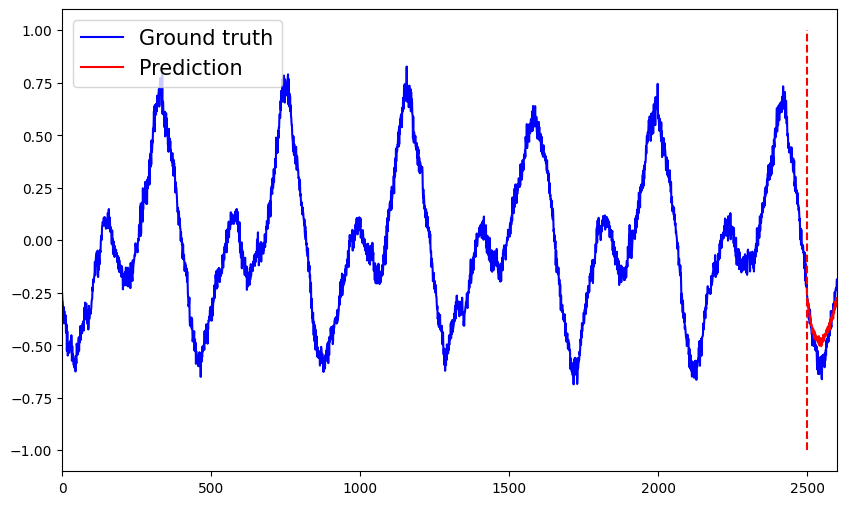

In [30]:
test_pred = lstm_network.predict(test_data).ravel()
test_label = data[10000:10000 + n_step*n_input + n_input]

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, n_step*n_input + n_input), test_label, 'b', label = 'Ground truth')
plt.plot(np.arange(n_step*n_input, n_step*n_input + n_input), test_pred, 'r', label = 'Prediction')
plt.vlines(n_step*n_input, -1, 1, colors = 'r', linestyles = 'dashed')
plt.legend(fontsize = 15, loc = 'upper left')
plt.xlim(0, len(test_label))
plt.show()

1/1 [==============================] - 0s 20ms/step


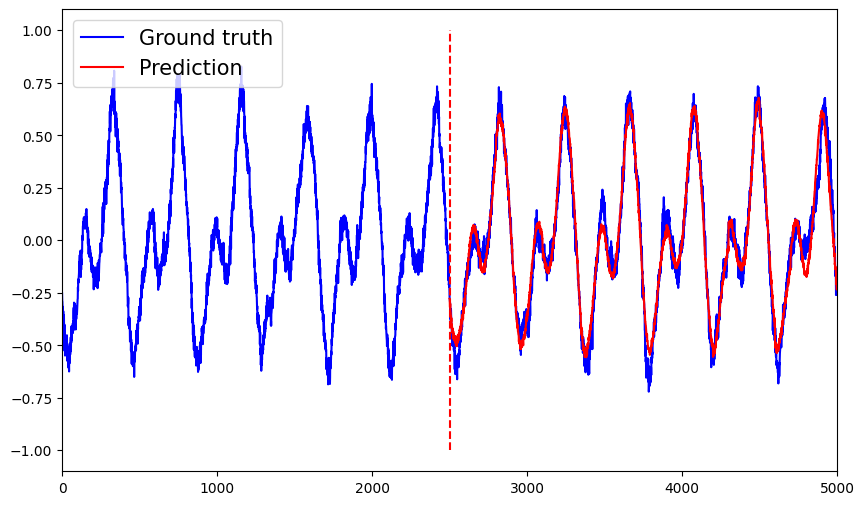

In [31]:
gen_signal = []
for i in range(n_step):
    test_pred = lstm_network.predict(test_data)
    gen_signal.append(test_pred.ravel())
    test_pred = test_pred[:, np.newaxis, :]

    test_data = test_data[:, 1:, :]
    test_data = np.concatenate([test_data, test_pred], axis = 1)

gen_signal = np.concatenate(gen_signal)

test_label = data[10000:10000 + n_step*n_input + n_step*n_input]

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, n_step*n_input + n_step*n_input), test_label, 'b', label = 'Ground truth')
plt.plot(np.arange(n_step*n_input,  n_step*n_input + n_step*n_input), gen_signal, 'r', label = 'Prediction')
plt.vlines(n_step*n_input, -1, 1, colors = 'r', linestyles = 'dashed')
plt.legend(fontsize=15, loc = 'upper left')
plt.xlim(0, len(test_label))
plt.show()